In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import PCA
from bilinear_model import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
plt.rcParams['font.size'] = 16

In [2]:
import matplotlib.colors as colors
from copy import copy, deepcopy
import matplotlib.ticker as ticker

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [3]:
mean_df = pd.read_csv("connection_matrix_mean.csv", index_col = 0)

In [4]:
mean_df = mean_df.rename(index={'xbc': 'bc5xbc'})
mean_df = mean_df.sort_index().sort_index(axis=1)
mean_df

,1wt,27,2an,2aw,2o,37c,37r,37v,3i,4i,...,63,6sn,6sw,72,73,7iv/r/d,82n/wo,82wi,8w,9w
bc1,1.765638,2.078257,2.253563,2.324735,2.321309,-0.468666,-0.352261,-0.451977,1.786638,-0.879778,...,-0.491603,-1.136757,-1.138290,0.398370,0.182421,-1.089168,0.010274,-0.385499,-1.140229,-1.140229
bc2,2.214331,1.960025,2.299652,2.257118,2.137831,0.267909,0.426871,0.304961,2.165173,-0.470123,...,0.187163,-1.133315,-1.137492,0.227581,0.212052,-1.023263,-0.028737,-0.465328,-1.140229,-1.140229
bc3a,0.014845,-0.062604,0.485903,-0.158017,-0.393949,0.636029,0.717180,0.710334,1.160862,2.102363,...,1.387802,-1.055766,-1.100811,-0.607863,-0.046697,-0.926425,-0.709379,-0.921696,-1.140229,-1.140229
bc3b,0.118872,0.046328,0.584665,-0.036917,-0.257395,0.496797,0.589220,0.566447,1.188170,2.007967,...,1.291898,-1.051465,-1.098341,-0.561795,-0.025702,-0.937863,-0.670452,-0.894768,-1.140229,-1.140229
bc4,0.471432,0.402518,0.944175,0.355128,0.094079,0.722966,0.836894,0.792993,1.542472,1.828827,...,1.413330,-1.039303,-1.086604,-0.405010,0.114936,-0.923305,-0.547103,-0.821611,-1.140229,-1.140229
bc5i,-0.851685,-0.546839,-0.786281,-0.813143,-0.819216,0.181085,0.035943,0.098772,-0.710858,-0.713936,...,1.268667,2.580273,2.447052,-0.382388,0.470584,0.932348,-0.707757,-0.867421,-1.073277,-1.121080
bc5o,-0.855314,-0.620546,-0.749512,-0.814676,-0.796450,-0.250678,-0.351711,-0.307808,-0.694386,-0.528597,...,1.280664,2.419237,2.315047,-0.571565,0.244686,0.137725,-0.703260,-0.919451,-1.101646,-1.132977
bc5t,-0.856793,-0.574459,-0.723707,-0.815525,-0.791575,0.216665,0.091783,0.152937,-0.676352,-0.404399,...,1.242985,1.898121,1.609563,-0.392948,0.529689,0.874217,-0.650643,-0.878301,-1.087786,-1.128714
bc5xbc,-0.965785,-0.778030,-0.915734,-0.933525,-0.927825,-0.603829,-0.690718,-0.657270,-0.862624,-0.813653,...,0.945038,2.483194,2.608063,-0.771328,-0.140417,-0.316393,-0.845175,-0.988764,-1.113474,-1.137804
bc6,-0.573996,0.106176,-0.521340,-0.545817,-0.597708,-0.468275,-0.486316,-0.457389,-0.457782,-0.569300,...,-0.036143,0.094611,0.195177,0.638912,0.835000,-0.116227,1.768752,2.018341,1.953503,1.739948


In [5]:
rgc_mean_df = pd.read_csv("rgc_mean_df.csv", index_col = 0)
rgc_mean_df

,0,1,2,3,4,5,6,7,8,9,...,11313,11314,11315,11316,11317,11318,11319,11320,11321,11322
annotated,,,,,,,,,,,,,,,,,,,,,
1wt,0.734087,0.219663,0.085508,0.348167,0.229863,0.210750,-0.045596,-0.418151,-0.884077,0.062686,...,0.003005,0.013081,-0.003401,-0.000503,-0.003288,-0.018939,0.000472,0.002454,-0.001653,0.027318
27,0.266574,0.085414,0.900908,0.170533,0.211741,-0.271182,-0.144616,-0.385695,-0.482542,-0.347414,...,-0.000371,-0.000516,-0.002263,-0.002927,-0.000128,-0.002763,0.002961,-0.002036,0.001491,-0.003514
2an,-0.273371,-0.069753,0.125894,0.731196,-0.179561,-0.385569,0.321048,0.307743,-0.476605,-0.060951,...,0.002854,-0.001409,-0.000827,-0.000648,0.000662,-0.000478,0.000231,-0.000028,-0.003533,-0.000743
2aw,-0.050620,0.002029,1.217835,0.032232,-0.319361,0.325150,-0.243572,0.047176,0.293808,-0.054108,...,-0.000596,-0.001374,-0.001108,0.001013,0.000169,-0.000258,0.000152,0.002520,-0.000336,-0.000081
2o,0.262262,0.074625,0.666135,-0.182457,0.663008,-0.946841,0.070280,-0.402092,-0.673471,-0.350841,...,-0.003308,0.000735,-0.002701,-0.003693,0.004834,-0.001543,0.000467,-0.000882,-0.000807,0.001888
37c,0.151719,0.075859,0.371623,-0.521624,0.460503,-1.175089,0.167592,-0.033815,-0.022763,0.305956,...,0.004722,0.002538,-0.000804,0.002542,0.000021,-0.006295,-0.000285,-0.003541,-0.000301,0.002476
37r,0.257134,0.072888,-0.484186,0.081737,-1.096200,-0.004890,0.041373,-0.263393,0.095565,0.289155,...,-0.003840,0.000389,0.003030,0.002769,-0.004312,0.000400,0.003294,0.005890,0.003214,0.001189
37v,0.206417,0.080536,-0.252105,-0.080018,-0.733437,-0.500676,0.160943,-0.202851,0.152112,0.473210,...,0.001562,-0.001399,-0.001862,0.003782,0.002089,0.000251,-0.000962,-0.001043,-0.002247,-0.001884
3i,0.302520,0.135617,-0.090614,-0.309867,0.417917,0.230599,0.035816,0.350031,-0.198840,-0.506789,...,-0.000977,-0.003748,0.002567,0.001712,0.001563,0.001945,-0.001953,0.001972,0.000161,0.000664


In [6]:
bc_mean_df = pd.read_csv("bc_mean_df.csv", index_col = 0)
bc_mean_df

,0,1,2,3,4,5,6,7,8,9,...,3132,3133,3134,3135,3136,3137,3138,3139,3140,3141
annotated,,,,,,,,,,,,,,,,,,,,,
bc1,-0.124906,0.651657,-0.056886,-0.216782,0.045616,0.479158,-0.149424,0.049344,0.495078,0.489007,...,-0.008796,0.000440,0.007551,0.008130,0.004492,0.004298,0.016566,-0.011721,-0.011109,0.005865
bc2,-0.989565,0.777719,0.605643,-0.681671,0.449138,0.092114,-0.816348,-0.311813,-0.484495,-0.178149,...,0.007072,-0.003857,-0.004411,-0.001817,-0.002593,-0.004343,0.000431,0.016340,0.002584,0.004137
bc3a,-0.312601,0.550331,0.861689,-0.011634,0.587257,-0.017278,1.106711,0.103689,0.112572,-0.092369,...,0.002701,0.008346,0.005519,-0.010258,0.008298,-0.001294,0.005828,-0.022214,0.001030,0.000828
bc3b,1.020344,0.794336,-0.185964,0.002216,-0.263068,-0.357799,0.064340,0.071248,-0.539451,0.082165,...,-0.001006,0.001428,-0.001938,-0.002314,0.002996,-0.003004,-0.010524,0.012333,0.000123,-0.010550
bc4,0.918902,1.280392,-0.519064,0.046281,-0.185773,0.078908,-0.144013,-0.225504,0.885732,-0.304827,...,-0.000219,-0.007172,0.000995,0.009499,-0.003165,0.014747,-0.000894,0.007738,0.012197,0.005970
bc5i,0.545519,-1.074042,-0.375155,-0.419846,0.360277,-0.333709,-0.106512,0.093378,0.195083,-0.087044,...,-0.000446,-0.002343,-0.002446,0.007161,-0.002986,-0.009783,-0.002002,0.002688,0.003323,0.002638
bc5o,0.559864,-0.779252,1.362928,0.438057,-0.296719,0.316644,-0.251170,-0.139952,-0.028082,0.087289,...,-0.000734,-0.011060,-0.001595,-0.007631,0.003034,0.003682,-0.012204,-0.008704,-0.000075,0.000178
bc5t,0.187583,-0.463991,0.684399,-0.002862,-0.504875,0.545256,-0.117915,-0.032983,0.263351,-0.333134,...,0.015130,-0.003417,-0.000608,-0.006999,-0.009451,-0.003644,0.029710,0.000160,0.014374,-0.005725
bc5xbc,0.493104,-0.686548,0.159462,-0.332810,0.173096,-0.132139,-0.030842,0.425515,-0.052987,0.171214,...,-0.003294,0.020352,-0.003623,0.024810,-0.018459,0.017573,0.003789,-0.004721,-0.001314,0.000298


In [7]:
bc_pca_components = np.load('bc_pca_components.npy')
A_est = np.load('A_est.npy')
bc_var = np.load('bc_var.npy')
rgc_pca_components = np.load('rgc_pca_components.npy')
B_est = np.load('B_est.npy')
rgc_var = np.load('rgc_var.npy')

In [8]:
with open('rgc_df_gene_selected.pkl', 'rb') as f:
    rgc_df = pickle.load(f)
rgc_df_all = rgc_df.copy()
rgc_df_all

_index,GM37381,RP1,MRPL15,RGS20,NPBWR1,4732440D04RIK,GM26901,MYBL1,VCPIP1,SNHG6,...,GM28510,GM20831,GM20792,GM21209,GM29082,GM29564,GM21760,GM21409,GM20820,GM47283
annotated,,,,,,,,,,,,,,,,,,,,,
25,0.0,0.0,0.000000,0.849207,0.0,0.0,0.0,0.0,0.849207,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.301712
3,0.0,0.0,0.000000,1.146473,0.0,0.0,0.0,0.0,0.729256,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
28,0.0,0.0,0.658763,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
28,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.571013,0.571013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
14,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.589141,0.957386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.0,0.0,0.333000,0.333000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
15,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.420690,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.420690


In [9]:
df = pd.read_csv("RGC_type_correspondence_combined.csv")
df

,Goetz et al. (2022) Type,Bae et al. (2018) Eyewire type,Tran et al. (2019) Cluster
0,ON sus alpha,8w,C43
1,OFFhOS,2aw,C9
2,OFFvOS,2aw,C5
3,ON tr SmRF,6sn,C30
4,OFF tr alpha,4ow,C45
5,OFF tr SmRF,4i,C21
6,ONhOS SmRF,82wi,C27
7,ONhOS LgRF,82n/wo,C36
8,ONvOS SmRF,72,C38
9,"ON DS sus DN, T, V",7iv/r/d,C10


In [10]:
# Initialize an empty dictionary
rgc_map = {}

# Iterate over the rows of the dataframe
for index, row in df.iterrows():
    # Extract the value and key from the row
    value = row['Bae et al. (2018) Eyewire type']
    key = row['Tran et al. (2019) Cluster']
    
    # Extract the number from the 'key' column
    key_number = int(key[1:])
    
    # Adjust the key number by subtracting 1
    adjusted_key = key_number - 1
    
    # Add the key-value pair to the dictionary
    rgc_map[adjusted_key] = value

# Print the resulting dictionary
print(rgc_map)

{42: '8w', 8: '2aw', 4: '2aw', 29: '6sn', 44: '4ow', 20: '4i', 26: '82wi', 35: '82n/wo', 37: '72', 9: '7iv/r/d', 15: '37v', 23: '37r', 12: '5si', 5: '5so', 1: '5ti', 10: '51', 2: '63', 13: '73', 17: '3i', 24: '2o', 25: '27', 30: '9w', 41: '1wt', 11: '37c', 3: '2an', 40: '6sw'}


In [11]:
# Annotate data
rgc_df = rgc_df[rgc_df.index.isin(rgc_map.keys())]
rgc_df = rgc_df.rename(index = rgc_map)
rgc_df

_index,GM37381,RP1,MRPL15,RGS20,NPBWR1,4732440D04RIK,GM26901,MYBL1,VCPIP1,SNHG6,...,GM28510,GM20831,GM20792,GM21209,GM29082,GM29564,GM21760,GM21409,GM20820,GM47283
annotated,,,,,,,,,,,,,,,,,,,,,
27,0.0,0.0,0.000,0.849207,0.0,0.0,0.0,0.0,0.849207,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.301712
2an,0.0,0.0,0.000,1.146473,0.0,0.0,0.0,0.0,0.729256,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
37c,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.822634,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.822634
37r,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.986616,0.514533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3i,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.945292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iv/r/d,0.0,0.0,0.333,0.333000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
63,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
37v,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.420690,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.420690


In [12]:
with open('bc_df_gene_selected.pkl', 'rb') as f:
    bc_df = pickle.load(f)
bc_df_all = bc_df.copy()
bc_df_all

_index,XKR4,RP1,SOX17,RGS20,4732440D04RIK,GM26901,SNTG1,MYBL1,PPP1R42,CPA6,...,MID1,GM21887,ASMT,ZFY1,USP9Y,GM21704,KDM5D,GM29650,GM28919,GM47283
annotated,,,,,,,,,,,,,,,,,,,,,
6,1.708522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
5,2.684568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
14,1.176548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.176548,0.0,0.0,0.000000
14,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.850446
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.087015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.087015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
8,2.510073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
14,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.092912,0.0,0.0,1.092912


In [13]:
bc_map = {
    0:"bc1",
    1:"bc1",
    2:"bc2",
    3:"bc3a",
    4:"bc3b",
    5:"bc4",
    6:"bc5i",
    7:"bc5o",
    8:"bc5t",
    #9:"xbc",
    9:"bc5xbc",
    10:"bc6",
    11:"bc7",
    12:"bc8/9",
    13:"bc8/9",
}

In [14]:
# Annotate data
bc_df = bc_df[bc_df.index.isin(bc_map.keys())]
bc_df = bc_df.rename(index = bc_map)
bc_df

_index,XKR4,RP1,SOX17,RGS20,4732440D04RIK,GM26901,SNTG1,MYBL1,PPP1R42,CPA6,...,MID1,GM21887,ASMT,ZFY1,USP9Y,GM21704,KDM5D,GM29650,GM28919,GM47283
annotated,,,,,,,,,,,,,,,,,,,,,
bc5i,1.708522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
bc4,2.684568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
bc1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
bc3b,1.191177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.191177,0.0,0.0,2.318833
bc1,2.059829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bc5o,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3.290093
bc3b,1.087015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.087015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
bc5t,2.510073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [38]:
n_genes = 50

In [39]:
# Load the dictionary from the pickle file
with open("bc_labels_dim0.pickle", "rb") as f:
    bc_labels_dim0 = pickle.load(f)
    
with open("bc_labels_dim1.pickle", "rb") as f:
    bc_labels_dim1 = pickle.load(f)
    
with open("bc_value_dim0.pickle", "rb") as f:
    bc_value_dim0 = pickle.load(f)
    
with open("bc_value_dim1.pickle", "rb") as f:
    bc_value_dim1 = pickle.load(f)

In [40]:
def get_genelists (df, w, df0, value_dict):
    df2 = df[df[w] != 0]
    df2 = df2.sort_values(by = [w], ascending = False)
    df2.to_csv(w+'.csv')

    df2_ = df0[list(df2.index)]
    df2_ = df2_.mask(df2_== 0, np.nan)
    df2_['labels'] = df2_.index
    df2__ = df2_.groupby(['labels']).mean()
    df2__ = (df2__-df2__.mean(axis = 0))/df2__.std(axis = 0)
    df2__ = df2__.T
    df2__.drop(columns=['abs_w1','abs_w2','w1','w2'], inplace = True)
    column_labels = df2__.columns[:]
    sorted_column_labels = sorted(column_labels, key=lambda x: value_dict.get(x, 0))
    df2__ = df2__[sorted_column_labels]
    df2__.to_csv(w+'_ExpMat.csv')
    df2__ = df2__.fillna(0)
    df2_ = df2_.fillna(0)

    df22_ = df0[list(df2.index)]
    df22_[df22_ > 0] = 1
    df22_['labels'] = df22_.index
    df22__ = df22_.groupby(['labels']).mean()
    df22__ = df22__.T
    df22__.drop(columns=['abs_w1','abs_w2','w1','w2'], inplace = True)
    sorted_column_labels = sorted(column_labels, key=lambda x: value_dict.get(x, 0))
    df22__ = df22__[sorted_column_labels]
    df22__.to_csv(w+'_PercMat.csv')
    return df2, df2__, df22__

In [41]:
bc_df2 = bc_df.T
bc_df2["abs_w1"] = abs(np.dot(bc_pca_components, A_est))[:,0]
bc_df2["w1"] = np.dot(bc_pca_components, A_est)[:,0]
bc_df2["abs_w2"] = abs(np.dot(bc_pca_components, A_est))[:,1]
bc_df2["w2"] = np.dot(bc_pca_components, A_est)[:,1]
bc_df2

/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/1175236888.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bc_df2["abs_w1"] = abs(np.dot(bc_pca_components, A_est))[:,0]
/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/1175236888.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bc_df2["w1"] = np.dot(bc_pca_components, A_est)[:,0]
/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/1175236888.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

annotated,bc5i,bc4,bc1,bc3b,bc1,bc3b,bc7,bc5i,bc3b,bc4,...,bc2,bc5o,bc3b,bc5t,bc3b,bc1,abs_w1,w1,abs_w2,w2
_index,,,,,,,,,,,,,,,,,,,,,
XKR4,1.708522,2.684568,0.0,1.191177,2.059829,0.000000,2.33954,0.000000,1.712234,1.756601,...,3.310512,0.000000,1.087015,2.510073,0.0,0.000000,0.011952,-0.011952,0.088645,-0.088645
RP1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000056,0.000056,0.005070,0.005070
SOX17,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.008151,0.008151,0.010466,-0.010466
RGS20,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.006209,-0.006209,0.008341,0.008341
4732440D04RIK,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.004753,-0.004753,0.003578,0.003578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM21704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.003125,0.003125,0.002822,0.002822
KDM5D,0.000000,0.000000,0.0,1.191177,0.000000,0.000000,0.00000,0.000000,1.184993,0.000000,...,1.837343,0.000000,0.000000,0.000000,0.0,1.730714,0.009522,0.009522,0.011908,-0.011908
GM29650,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.005549,0.005549,0.002016,0.002016


In [42]:
bc_df2_sorted = bc_df2.sort_values(by = "abs_w1")
res = ""
for i in bc_df2_sorted.tail(n_genes).index:
    res += i
    res += " "
bc_res_list1 = bc_df2_sorted.tail(n_genes)
res

'SLC24A4 EFNA5 GRIK1 SLC35F1 FILIP1L MEIS2 RAB3C PTPRR CNMD SOX6 DACH1 ST6GALNAC5 CPLX4 VSX1 PCP4L1 ABCA4 E130114P18RIK GM45341 4930555F03RIK P3H2 PITPNC1 GM45321 SLC24A3 KCNH7 SLC24A2 ERBB4 TSHZ2 PCDH9 SULF1 MAML2 GRID2 MAN1A PTPRM GM2516 CCK NFIA ESRRG GNGT1 EPHA3 GSG1 GM45323 GRIN3A CDH11 CHST9 PLCB1 UNC13C GPC6 C130073E24RIK RELN UNC5D '

In [43]:
bc_l1_df1, bc_l1_df2, bc_l1_df3 = get_genelists (bc_df2_sorted.tail(n_genes), "w1", bc_df2_sorted.tail(n_genes).T, bc_value_dim0)
bc_l1_df1

annotated,bc5i,bc4,bc1,bc3b,bc1,bc3b,bc7,bc5i,bc3b,bc4,...,bc2,bc5o,bc3b,bc5t,bc3b,bc1,abs_w1,w1,abs_w2,w2
_index,,,,,,,,,,,,,,,,,,,,,
CDH11,0.000000,2.057444,2.068235,1.191177,0.000000,0.000000,0.000000,0.000000,2.682663,2.732947,...,0.000000,2.263337,1.930974,3.161740,1.936033,0.000000,0.129861,0.129861,0.005972,0.005972
GSG1,0.000000,2.684568,0.000000,2.690952,0.000000,2.962404,0.000000,2.075514,3.341021,3.004239,...,0.000000,2.009735,2.691776,0.000000,2.554308,0.000000,0.112594,0.112594,0.041832,-0.041832
EPHA3,0.000000,2.984233,2.068235,1.719529,0.000000,0.000000,0.000000,0.000000,2.826996,2.877765,...,3.636502,2.903082,1.595505,0.000000,3.599698,0.000000,0.111573,0.111573,0.113734,-0.113734
GNGT1,0.000000,0.000000,0.000000,1.719529,0.000000,2.319659,0.000000,0.000000,2.055660,0.000000,...,0.000000,3.833615,2.382047,1.895055,1.936033,0.000000,0.110158,0.110158,0.050956,0.050956
ESRRG,0.000000,0.000000,0.000000,0.000000,2.687116,2.522946,0.000000,2.075514,1.184993,2.102801,...,0.000000,2.777356,2.181731,0.000000,0.000000,0.000000,0.108750,0.108750,0.021398,0.021398
NFIA,0.000000,2.057444,0.000000,2.063420,0.000000,1.720282,0.000000,2.703860,2.055660,1.756601,...,0.000000,1.669132,0.000000,2.888077,0.000000,0.000000,0.108095,0.108095,0.066672,0.066672
MAN1A,0.000000,1.811473,0.000000,1.191177,2.059829,0.000000,0.000000,0.000000,2.310816,1.222704,...,0.000000,0.000000,1.595505,0.000000,0.000000,1.730714,0.098755,0.098755,0.018832,-0.018832
ERBB4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088664,0.088664,0.071543,-0.071543
SLC24A2,0.000000,0.000000,0.000000,1.719529,0.000000,2.319659,0.000000,3.086757,0.000000,1.756601,...,0.000000,0.000000,2.181731,3.161740,0.000000,0.000000,0.088095,0.088095,0.038030,0.038030


/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/2936586225.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(bc_l1_df1.index), fontsize=10)


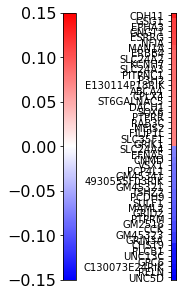

In [44]:
a = np.array(bc_l1_df1[['w1']])

elev_min=-0.15
elev_max=0.15
mid_val=0

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)   
cax = ax.matshow(a, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
fig.colorbar(cax, location='left')
ax.set_yticklabels([''] + list(bc_l1_df1.index), fontsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.get_xaxis().set_visible(False)
plt.show()
fig.savefig('color_bar.svg', bbox_inches='tight')

/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/3182108102.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(bc_l1_df1.index), fontsize=10)


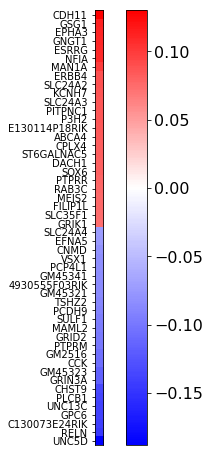

In [45]:
a = np.array(bc_l1_df1[['w1']])

elev_min=min(a)
elev_max=max(a)
mid_val=0

fig, ax = plt.subplots(figsize=(8,8))   
cax = ax.matshow(a, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
fig.colorbar(cax)
ax.set_yticklabels([''] + list(bc_l1_df1.index), fontsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.get_xaxis().set_visible(False)
plt.show()
fig.savefig('bc_w1_gene_list.svg', bbox_inches='tight')

In [46]:
bc_df2_sorted = bc_df2.sort_values(by = "abs_w2")
res = ""
for i in bc_df2_sorted.tail(n_genes).index:
    res += i
    res += " "
bc_res_list2 = bc_df2_sorted.tail(n_genes)
res

'CADPS2 VAT1L LRRC4C XKR4 GM28905 IL1RAPL1 RELN LGR5 NKAIN3 GM26905 GSG1L2 SLITRK6 PRR16 FAT4 LARGE1 EBF1 REPS2 ADCY8 FAT3 PLXNA4 ESAM VWC2L NRXN1 DMD LHFPL3 ADAMTSL1 EPHA3 DSCAM GRIN2B GABRB1 EGFEM1 ST18 NETO1 KCNIP4 TMEFF2 NXPH1 NCAM2 PHACTR1 TACR3 RYR3 ADARB2 PRKG1 TRPM3 NLGN1 GALNTL6 PDE1A SLIT2 GRIK1 CNTNAP5A CNTN5 '

In [47]:
bc_l2_df1, bc_l2_df2, bc_l2_df3 = get_genelists (bc_df2_sorted.tail(n_genes), "w2", bc_df2_sorted.tail(n_genes).T, bc_value_dim1)
bc_l2_df1

annotated,bc5i,bc4,bc1,bc3b,bc1,bc3b,bc7,bc5i,bc3b,bc4,...,bc2,bc5o,bc3b,bc5t,bc3b,bc1,abs_w1,w1,abs_w2,w2
_index,,,,,,,,,,,,,,,,,,,,,
CNTN5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.944302,0.000000,0.000000,...,0.000000,3.785906,0.000000,4.575736,0.000000,0.000000,0.047836,0.047836,0.197089,0.197089
PRKG1,4.090510,0.000000,0.000000,0.000000,0.000000,0.000000,4.047581,2.075514,0.000000,0.000000,...,0.000000,4.247365,0.000000,2.888077,0.000000,0.000000,0.015309,-0.015309,0.152298,0.152298
ADARB2,3.615404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.438908,0.000000,0.000000,0.000000,0.000000,0.006140,0.006140,0.147834,0.147834
RYR3,1.708522,0.000000,0.000000,1.719529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.009735,1.930974,0.000000,0.000000,0.000000,0.003751,-0.003751,0.145516,0.145516
ST18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.738400,2.075514,0.000000,0.000000,...,0.000000,2.009735,0.000000,2.888077,0.000000,0.000000,0.072335,0.072335,0.122191,0.122191
VWC2L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.669132,0.000000,0.000000,0.000000,0.000000,0.044116,-0.044116,0.105657,0.105657
RELN,3.060751,0.000000,0.000000,0.000000,0.000000,0.000000,2.339540,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146245,-0.146245,0.092589,0.092589
CADPS2,0.000000,0.995651,0.000000,1.719529,0.000000,0.000000,0.000000,0.000000,1.184993,1.756601,...,0.000000,0.000000,0.000000,0.000000,1.936033,0.000000,0.000624,0.000624,0.087619,-0.087619
VAT1L,1.708522,0.995651,0.000000,1.191177,0.000000,0.000000,1.738400,0.000000,0.000000,1.222704,...,0.000000,0.000000,1.930974,0.000000,0.000000,0.000000,0.003707,0.003707,0.087696,-0.087696


/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/2844219514.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(bc_l2_df1.index), fontsize=10)


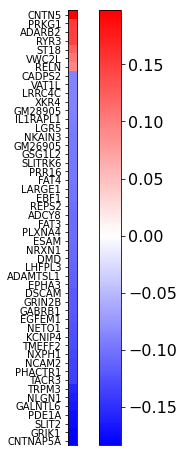

In [48]:
a = np.array(bc_l2_df1[['w2']])

elev_min=min(a)
elev_max=max(a)
mid_val=0

fig, ax = plt.subplots(figsize=(8,8))   
cax = ax.matshow(a, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
fig.colorbar(cax)
ax.set_yticklabels([''] + list(bc_l2_df1.index), fontsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.get_xaxis().set_visible(False)
plt.show()
fig.savefig('bc_w2_gene_list.svg', bbox_inches='tight')

In [55]:
# Load the dictionary from the pickle file
with open("rgc_labels_dim0.pickle", "rb") as f:
    rgc_labels_dim0 = pickle.load(f)
    
with open("rgc_labels_dim1.pickle", "rb") as f:
    rgc_labels_dim1 = pickle.load(f)
    
# Load the dictionary from the pickle file
with open("rgc_value_dim0.pickle", "rb") as f:
    rgc_value_dim0 = pickle.load(f)
    
with open("rgc_value_dim1.pickle", "rb") as f:
    rgc_value_dim1 = pickle.load(f)

In [56]:
rgc_df2 = rgc_df.T
rgc_df2["abs_w1"] = abs(np.dot(rgc_pca_components, B_est))[:,0]
rgc_df2["w1"] = np.dot(rgc_pca_components, B_est)[:,0]
rgc_df2["abs_w2"] = abs(np.dot(rgc_pca_components, B_est))[:,1]
rgc_df2["w2"] = np.dot(rgc_pca_components, B_est)[:,1]
rgc_df2

/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/4016614822.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rgc_df2["abs_w1"] = abs(np.dot(rgc_pca_components, B_est))[:,0]
/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/4016614822.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rgc_df2["w1"] = np.dot(rgc_pca_components, B_est)[:,0]
/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/4016614822.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

annotated,27,2an,37c,37r,3i,6sn,5ti,2aw,4i,37v,...,63,7iv/r/d,63,37v,73,2an,abs_w1,w1,abs_w2,w2
_index,,,,,,,,,,,,,,,,,,,,,
GM37381,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.00000,0.000000,0.000000,0.002159,0.002159,0.002371,-0.002371
RP1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.00000,0.000000,0.000000,0.004118,0.004118,0.002683,0.002683
MRPL15,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.333,0.0,0.00000,0.000000,0.000000,0.013076,0.013076,0.003736,0.003736
RGS20,0.849207,1.146473,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.360987,...,0.820279,0.333,0.0,0.00000,0.904456,0.000000,0.011899,-0.011899,0.056797,0.056797
NPBWR1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.00000,0.000000,0.000000,0.007897,-0.007897,0.000170,-0.000170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM29564,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.00000,0.000000,0.000000,0.006994,0.006994,0.007000,-0.007000
GM21760,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.00000,0.000000,0.000000,0.000077,0.000077,0.002446,0.002446
GM21409,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [57]:
rgc_df2_sorted = rgc_df2.sort_values(by = "abs_w1")
res = ""
for i in rgc_df2_sorted.tail(n_genes).index:
    res += i
    res += " "
rgc_res_list1 = rgc_df2_sorted.tail(n_genes)
res

'NAV3 FLRT2 MAML3 TIMP3 CPLX2 NRXN3 CGNL1 AC129186.1 TRHDE CTXN3 EOMES GABRG3 SPON1 GRIA3 TENM1 WDR72 ASTN2 ETV1 OPN4 GABRB1 NPPB PTCHD4 PTPRO GRID2 TMEM178 DGKG NR2F2 ADAMTS2 SLC8A1 IGF1 TUSC5 IL1RAPL2 LMO1 PRKCQ GUCY1A1 GM20754 TLL1 CDH12 ATP2B4 OPRM1 ADAMTS5 SFRP2 COCH PCDH11X SLC44A5 CNTNAP5C PCDH7 DAB1 SORCS1 IGFBP6 '

In [58]:
rgc_l1_df1, rgc_l1_df2, rgc_l1_df3 = get_genelists (rgc_df2_sorted.tail(n_genes), "w1", rgc_df2_sorted.tail(n_genes).T, rgc_value_dim0)
rgc_l1_df1

annotated,27,2an,37c,37r,3i,6sn,5ti,2aw,4i,37v,...,63,7iv/r/d,63,37v,73,2an,abs_w1,w1,abs_w2,w2
_index,,,,,,,,,,,,,,,,,,,,,
PCDH7,2.568032,1.851236,3.034258,1.799468,1.422416,3.620775,2.346489,0.634903,3.037408,2.642077,...,2.618222,1.425799,2.504766,2.118924,0.000000,1.830099,0.118835,0.118835,0.047290,0.047290
ADAMTS5,0.000000,0.000000,0.000000,0.000000,1.422416,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.820279,0.000000,0.000000,0.000000,0.000000,0.000000,0.103272,0.103272,0.034251,-0.034251
LMO1,0.849207,0.000000,0.493625,0.290001,0.000000,0.948236,1.131317,0.000000,0.000000,0.000000,...,0.820279,0.000000,0.000000,0.000000,0.551177,0.000000,0.093539,0.093539,0.080522,0.080522
TUSC5,0.849207,0.729256,0.493625,1.104783,0.000000,1.991240,1.423013,0.000000,1.460594,0.000000,...,1.995470,0.000000,2.082616,0.000000,0.551177,1.420866,0.092002,0.092002,0.045483,0.045483
GRID2,0.849207,0.000000,0.000000,0.000000,0.945292,0.582538,1.423013,0.000000,2.030388,0.000000,...,1.571403,0.000000,1.651589,0.000000,0.000000,0.000000,0.085090,0.085090,0.020093,0.020093
PTCHD4,0.849207,1.146473,1.267785,0.852590,0.945292,1.877025,2.609954,1.020174,1.785537,1.499167,...,1.571403,1.090492,0.877586,0.943531,0.551177,0.716327,0.083384,0.083384,0.104445,0.104445
ETV1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081106,0.081106,0.122542,0.122542
TENM1,0.849207,0.000000,1.267785,1.104783,0.000000,0.582538,1.131317,0.000000,0.976166,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.716327,0.080055,0.080055,0.069695,0.069695
GRIA3,0.000000,1.439980,1.069777,1.547714,0.000000,0.948236,1.648558,0.000000,0.976166,1.283284,...,1.995470,0.000000,0.877586,0.420690,0.551177,1.129401,0.079896,0.079896,0.031801,0.031801


/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/1514360818.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(rgc_l1_df1.index), fontsize=10)


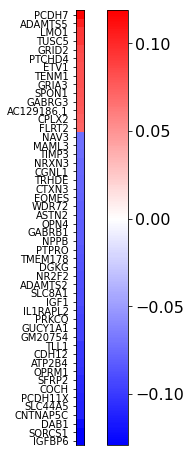

In [59]:
a = np.array(rgc_l1_df1[['w1']])

elev_min=min(a)
elev_max=max(a)
mid_val=0

fig, ax = plt.subplots(figsize=(8,8))   
cax = ax.matshow(a, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
fig.colorbar(cax)
ax.set_yticklabels([''] + list(rgc_l1_df1.index), fontsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.get_xaxis().set_visible(False)
plt.show()
fig.savefig('rgc_w1_gene_list.svg', bbox_inches='tight')

In [60]:
rgc_df2_sorted = rgc_df2.sort_values(by = "abs_w2")
res = ""
for i in rgc_df2_sorted.tail(n_genes).index:
    res += i
    res += " "
rgc_res_list2 = rgc_df2_sorted.tail(n_genes)
res

'NRG1 SDK2 CALCA FAM19A4 GPR101 NRGN PLXNA4 BARHL2 PDE1A GAS7 B230209E15RIK IGFBP6 PNLIP NKAIN3 GABRG3 MYO5B CCDC172 PTN GLP2R THSD7B NRXN3 LRRC4C PRDM16 CSMD3 CHRM2 MYF6 KITL STXBP6 CHSY3 PTCHD4 PAPPA CHRNA3 KLHL1 A330008L17RIK UTS2B SLC44A5 PPP1R1C 4833423E24RIK SLITRK6 POSTN ETV1 TSHZ2 RGS6 NELL1 RPRM CDH8 SNTB1 POU4F3 PLXNA2 MAFB '

In [61]:
rgc_l2_df1, rgc_l2_df2, rgc_l2_df3 = get_genelists (rgc_df2_sorted.tail(n_genes), "w2", rgc_df2_sorted.tail(n_genes).T, rgc_value_dim1)
rgc_l2_df1

annotated,27,2an,37c,37r,3i,6sn,5ti,2aw,4i,37v,...,63,7iv/r/d,63,37v,73,2an,abs_w1,w1,abs_w2,w2
_index,,,,,,,,,,,,,,,,,,,,,
MAFB,0.000000,0.000000,0.000000,0.000000,0.000000,0.582538,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064204,0.064204,0.172874,0.172874
POU4F3,1.301712,0.000000,0.493625,0.000000,0.000000,0.000000,0.717776,0.000000,0.000000,1.154906,...,0.000000,0.000000,0.000000,0.000000,1.688575,0.716327,0.035352,0.035352,0.134134,0.134134
SNTB1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038668,0.038668,0.134033,0.134033
ETV1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081106,0.081106,0.122542,0.122542
POSTN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038504,0.038504,0.119028,0.119028
PPP1R1C,0.000000,0.000000,0.000000,0.000000,0.000000,0.948236,0.000000,0.000000,0.000000,0.625665,...,0.000000,0.000000,0.000000,0.715899,0.000000,0.000000,0.036859,0.036859,0.117897,0.117897
SLC44A5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.333000,0.000000,0.000000,0.000000,0.000000,0.111732,-0.111732,0.117454,0.117454
UTS2B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027851,0.027851,0.113419,0.113419
CHRNA3,0.000000,0.000000,1.069777,0.290001,0.000000,0.000000,0.000000,0.000000,0.000000,0.625665,...,0.000000,0.582381,0.000000,1.645596,0.904456,0.000000,0.019879,0.019879,0.109320,0.109320


/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_74391/2659984053.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(rgc_l2_df1.index), fontsize=10)


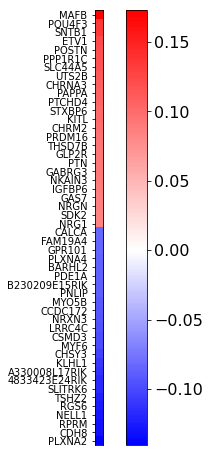

In [62]:
a = np.array(rgc_l2_df1[['w2']])

elev_min=min(a)
elev_max=max(a)
mid_val=0

fig, ax = plt.subplots(figsize=(8,8))   
cax = ax.matshow(a, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
fig.colorbar(cax)
ax.set_yticklabels([''] + list(rgc_l2_df1.index), fontsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.get_xaxis().set_visible(False)
plt.show()
fig.savefig('rgc_w2_gene_list.svg', bbox_inches='tight')